# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f


Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

print(grad_f(0.0, 0.0)) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

[1. 2.]
1.0


In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])
J_f=J(f)


print(J_f(0.0, 0.0)) # array([[1., 2.], [3., 4.]])
j = autograd.jacobian




[[1. 2.]
 [3. 4.]]


## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

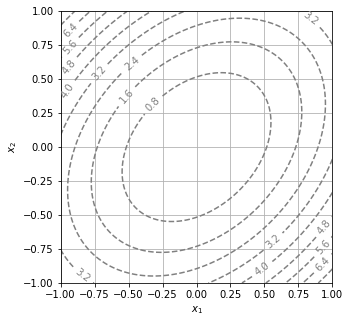

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

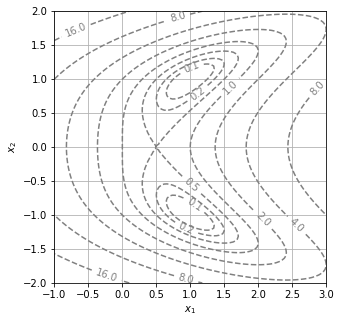

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

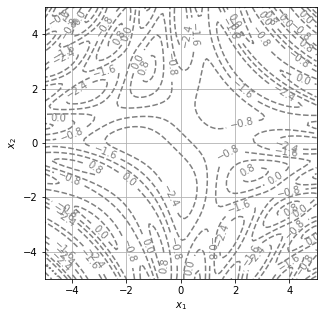

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

**Réponse** L'application Newton doit tracer des lignes de niveaux. En soi, les courbes vont être observée à l'oeil nu donc la précision des points n'est pas très importante. Malgré tout, il faudra que les courbes se referment correctement, donc on ne doit pas trop s'éloigner des valeurs réelles. 
En revanche, une précision trop basse pourrait amener l'algorithme à ne pas converger assez vite pour atteindre la précision donnée
On prendra donc epsilon fonction de N afin que si on autorise le programme à faire plus d'étape de calcul, la précision soit meilleure.

In [13]:
N = 1000
eps=1/N


**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
    def Newton(F, x0, y0, eps=eps, N=N):
        J_f = J(F)
        
        for i in range(N):
            # On calcule l'approximation suivante par la méthode de Newton
            A=((-np.linalg.inv(J_f(x0,y0))).dot(F(x0,y0)))
            x,y=A[0]+x0,A[1]+y0
            # On controle la distance à l'étape précédente.
            # Si les valeurs sont suffisament proche, l'algorithme converge et on arrête le calcul
            if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps: 
                return x, y 
            #Sinon, on reprend l'étape précédente en partant du point trouvé
            x0, y0 = x, y
        
        else:
            raise ValueError(f"no convergence in {N} steps.")


    #Pour pouvoir visualiser l'avancée du résultat vers la valeur réelle, on modifie un peu la fonction
    def NewtonTest(F, x0, y0, eps=eps, N=N):
       #On récupère maintenant les valeurs dans une liste, passer ensuite à plot
        listeX=[x0]
        listeY=[y0]
        a,b=x0,y0
        
        J_f = J(F) 
        for i in range(N):
            A=(-np.linalg.inv(J_f(a,b))).dot(F(a,b))
            h1,h2=A[0],A[1]
            x,y=h1+a,h2+b
            listeX.append(x)
            listeY.append(y)
            if np.sqrt((x - a)**2 + (y - b)**2) <= eps: 
                return listeX, listeY
            a, b = x, y
        else:
            raise ValueError(f"no convergence in {N} steps.")



**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

Le résultat de la fonction utilitaire, en partant de (0.8,0.8) pour f1:  (0.4472135970019964, 0.4472135970019964)
L'approche représentée visuellement : 


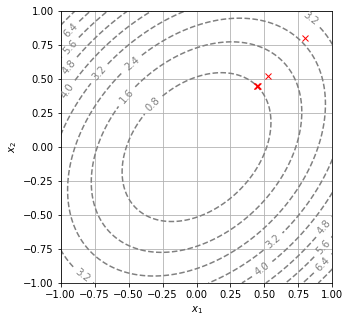

In [15]:
def F1(x,y):
    return np.array([f1(x,y)-0.8,x-y])
    
print("Le résultat de la fonction utilitaire, en partant de (0.8,0.8) pour f1: ", Newton (F1, 0.8, 0.8))
print("L'approche représentée visuellement : ")
Results=NewtonTest(F1, 0.8, 0.8)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 
)

plt.plot(Results[0],Results[1],'rx')
plt.show()

Le résultat de la fonction utilitaire, en partant de (0.8,0.8) pour f2:  (0.6198939014162629, 0.6198939014162629)
L'approche représentée visuellement : 


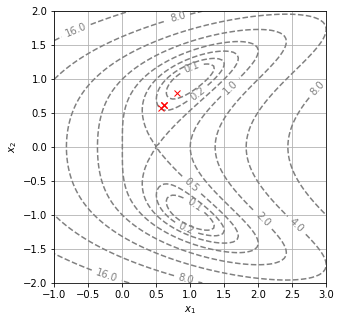

In [16]:
# On essaie une autre fonction
def F2(x,y):
    return np.array([f2(x,y)-0.2,x-y])
    
print("Le résultat de la fonction utilitaire, en partant de (0.8,0.8) pour f2: ", Newton (F2, 0.8, 0.8))
print("L'approche représentée visuellement : ")
Results=NewtonTest(F2, 0.8, 0.8)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.plot(Results[0],Results[1],'rx')

L'approche représentée visuellement : 


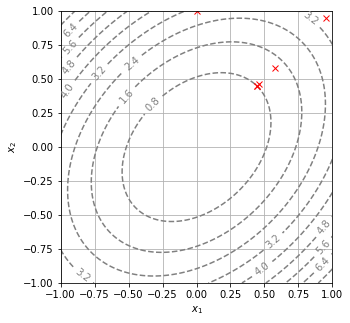

In [17]:
#On modifie le point de départ en (0,1)

    
print("L'approche représentée visuellement : ")
Results=NewtonTest(F1, 0. ,1.0)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 
)

plt.plot(Results[0],Results[1],'rx')
plt.show()

L'approche représentée visuellement : 


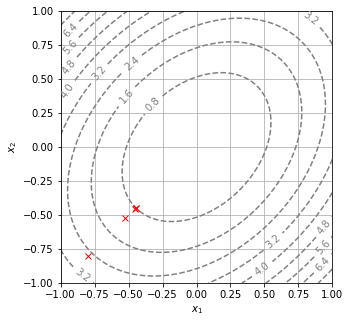

In [18]:
#On modifie le point de départ en (-0.8,-0.8)

    
print("L'approche représentée visuellement : ")
Results=NewtonTest(F1, -0.8 ,-0.8)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 
)

plt.plot(Results[0],Results[1],'rx')
plt.show()

L'approche représentée visuellement : 


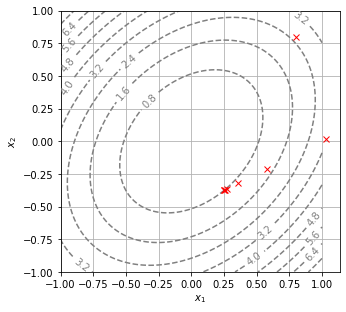

In [19]:
#On modifie la condition en x=2y+1
def autreF1(x,y):
    return np.array([f1(x,y)-0.8,x-2*y-1])
    

print("L'approche représentée visuellement : ")
Results=NewtonTest(autreF1, 0.8, 0.8)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 
)

plt.plot(Results[0],Results[1],'rx')
plt.show()

L'approche représentée visuellement : 


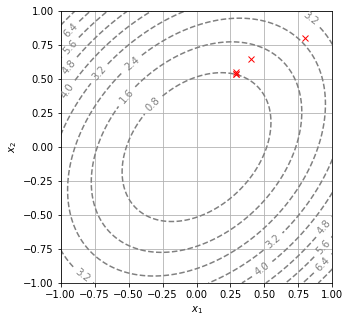

In [20]:
#On modifie la condition en x=y**2
def autreAutreF1(x,y):
    return np.array([f1(x,y)-0.8,x-y**2])
    

print("L'approche représentée visuellement : ")
Results=NewtonTest(autreAutreF1, 0.8, 0.8)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 
)

plt.plot(Results[0],Results[1],'rx')
plt.show()

L'approche représentée visuellement : 


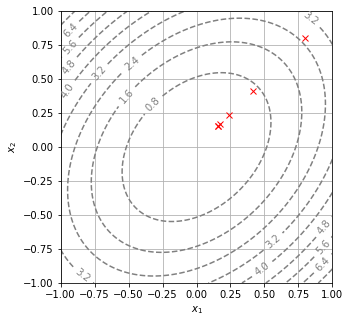

In [21]:
#On change le niveau de la courbe de niveau en 0.1
def F1(x,y):
    return np.array([f1(x,y)-0.1,x-y])
    
print("L'approche représentée visuellement : ")
Results=NewtonTest(F1, 0.8, 0.8)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 
)

plt.plot(Results[0],Results[1],'rx')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [22]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    #On initialise la première valeur
    tab=[[x0],[y0]]
   
    grad_f = grad(f)
    
    #On définit la matrice de rotation -pi/2
    rotation=np.array([[0,1],[-1,0]])
    #On définit la fonction de R**2 dans R**2 qui sera donnée à Newton
    #La condition se déplacer de delta à droite est traduite par:
    #le produit scalaire du gradient de f au point d'origine, que l'on à renversé de -pi/2 
    #et du vecteur entre le nouveau point et le point d'origine vaut delta 
    def F(x,y):
        grad=grad_f(x0,y0)
        gradUnitaire=grad*(np.sqrt(grad[0]**2+grad[1]**2))**-1
        return np.array([f(x,y)-c,np.dot(rotation.dot(gradUnitaire),(x-x0,y-y0))-delta])
    #On itère pour trouver point après point
    for n in range(0,N-1):        
        a,b=Newton(F,x0,y0)
        tab[0].append(a)
        tab[1].append(b)
        x0,y0=a,b
        
    return tab



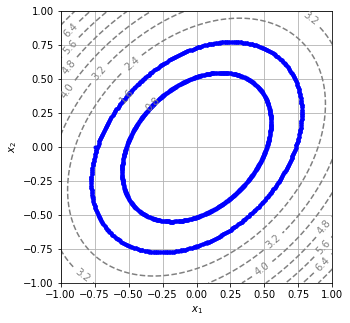

In [23]:
#Comme le recouvrement n'est pas géré, ces cellules mettent un peu de temps à s'executer
# On test f1
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 )

c=0.8
result=level_curve(f1,0.4472135970019964, 0.4472135970019964)
plt.plot(result[0],result[1],'b.')
-0.75, 0.
c=1.6   
result=level_curve(f1,-0.75, 0.)
plt.plot(result[0],result[1],'b.')


plt.show()

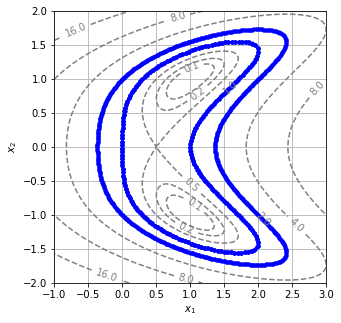

In [24]:
# On test f2
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
c=1.
result1=level_curve(f2,1., 0.)
plt.plot(result1[0],result1[1],'b.')

c=2
result1=level_curve(f2,2.,1. )
plt.plot(result1[0],result1[1],'b.')



plt.show()

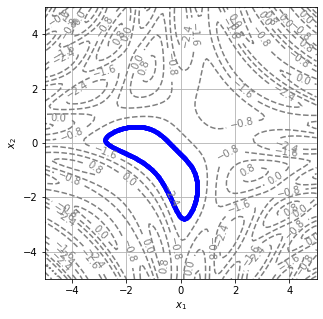

In [25]:
# On test f3
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

c=-2.4
result=level_curve(f3,-0.06454267749899904, -0.3473846556074643)
plt.plot(result[0],result[1],'b.')


plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [26]:
def level_curve_rec(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    #On initialise la première valeur
    tab=[[x0],[y0]]
   
    grad_f = grad(f)
    #On définit la matrice de rotation -pi/2
    rotation=np.array([[0,1],[-1,0]])
    #On définit la fonction de R**2 dans R**2 qui sera donnée à Newton
    #La condition se déplacer de delta à droite est traduite par:
    #le produit scalaire du gradient de f au point d'origine, que l'on à renversé de -pi/2 
    #et du vecteur entre le nouveau point et le point d'origine vaut delta 
    def F(x,y):
        grad=grad_f(x0,y0)
        gradUnitaire=grad*(np.sqrt(grad[0]**2+grad[1]**2))**-1
        return np.array([f(x,y)-c, np.dot(rotation.dot(gradUnitaire),(x-x0,y-y0))-delta])
    #On itère pour trouver point après point
    for n in range(0,N-1):        
        a,b=Newton(F,x0,y0)
        tab[0].append(a)
        tab[1].append(b)
        x0,y0=a,b
        #Pour arreter le recouvrement, on vérifie la distance entre chaque nouveau point et l'origine
        #S'il est trop près, on stoppe la fonction
        if np.sqrt((x0-tab[0][0])**2+(y0-tab[1][0])**2) < delta and n>7:
            
            return tab
    return tab


**Question** Valider graphiquement le résultat au moyen des exemples de référence.

Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :   49


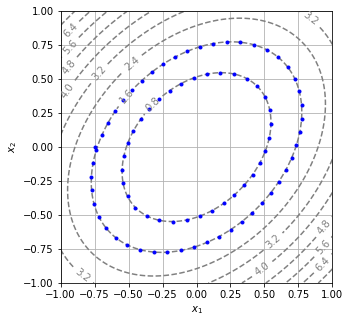

In [27]:
# On test f1
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 )

c=0.8    
result=level_curve_rec(f1,0.4472135970019964, 0.4472135970019964)
plt.plot(result[0],result[1],'b.')


c=1.6   
result=level_curve_rec(f1,-0.75, 0.)
plt.plot(result[0],result[1],'b.')

print("Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :  " ,len(result[0]))
plt.show()

Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :   95
Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :   114

 On remarque que parfois un point est doublé. Cela vient de notre condition d'arrêt, qui conserve le dernier point qui s'approche trop du premier

 Cela ne pose pas de problème dans la suite, puisque la fonction est utilisée pour approximer des aires. Si delta  devient plus petit, cette redondance est négligeable
Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :   95


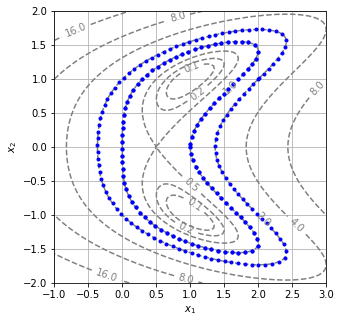

In [28]:
# On test f2
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
c=1.
result1=level_curve_rec(f2,1., 0.)
plt.plot(result1[0],result1[1],'b.')
print("Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :  " ,len(result1[0]))

c=2
result1=level_curve_rec(f2,2.,1. )
plt.plot(result1[0],result1[1],'b.')
print("Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :  " ,len(result1[0]))
print('\n', "On remarque que parfois un point est doublé. Cela vient de notre condition d'arrêt, qui conserve le dernier point qui s'approche trop du premier")
print('\n', "Cela ne pose pas de problème dans la suite, puisque la fonction est utilisée pour approximer des aires. Si delta  devient plus petit, cette redondance est négligeable")

c=1.
result1=level_curve_rec(f2,1., 0.)
plt.plot(result1[0],result1[1],'b.')
print("Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :  " ,len(result1[0]))


plt.show()


Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :   95


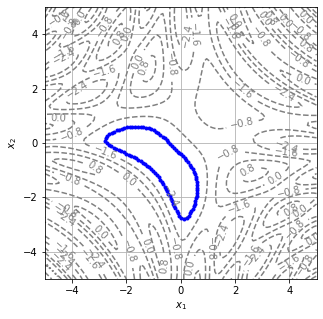

In [29]:
# On test f3
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

c=-2.4
result=level_curve_rec(f3,-0.06454267749899904, -0.3473846556074643)
plt.plot(result[0],result[1],'b.')
print("Pour vérifier qu'il n'y a pas recouvrement, on donne le nombre de point :  " ,len(result1[0]))

plt.show()


 Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [30]:


def distance_zero(x,y):
    return x**2+y**2

borneinf1=-1
bornesup1=1
borneinf2=-1
bornesup2=1
#il faut borner le domaine d'étude et je n'ai pas trouvé mieux que ça

def area_squares(f,c,h, borneinf1, bornsup1, borneinf2, bornesup2):
    bi1, bs1 = borneinf1, bornesup1 #bornes des abscisses
    bi2, bs2 = borneinf2, bornesup2 #bornes des ordonnées
    n=int((bs2-bi2)/h +1)
    m=int((bs1-bi1)/h +1)
    x0,y0= bi1+(h/np.sqrt(2)), bi2+(h/np.sqrt(2))#on se place au centre du petit carré en bas à gauche
    A=0
    for i in range (n):
        for j in range (m):
            if f(x0+j*h, y0+i*h)<=c:
                A+=h**2
    return A

def erreur(f,c,h):
    pas=h
    aire=area_squares(f,c,pas,borneinf1,bornesup1,borneinf2,bornesup2)
    return abs(aire - np.pi)#pour voir l'erreur sur l'aire du disque unité

print("aire d'après les carrés",area_squares(distance_zero, 1, 0.01, borneinf1, bornesup1, borneinf2, bornesup2))
#pour h=0.01 ca se fait vite mais comme complexité quadratique, très long pour 0.0001
print("erreur", erreur (distance_zero, 1,0.01))




aire d'après les carrés 3.1418000000022057
erreur 0.0002073464124126012


On obtient une droite linéaire, donc l'erreur est une puissance du pas


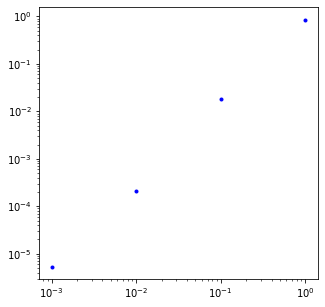

In [31]:
#On trace le logarithme de l'erreur en fonction du logarithme des pas
les_pas=np.array([10**(-i) for i in range (4)])
erreurs=np.array([erreur(distance_zero, 1, h) for h in les_pas ])
plt.plot(les_pas, erreurs, '.b')
plt.loglog()
print("On obtient une droite linéaire, donc l'erreur est une puissance du pas")
plt.show()


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [32]:
#on peut effectuer le calcul d'aire dans un while avec la valeur d'erreur comme condition d'arrêt (while er>10**-2)
#(on calculerait l'erreur à chaque fin de boucle)
#et à chaque retour, on avancerait d'un cran dans l'array des pas pour avoir une valeur d'aire plus précise

def aire_precision (f, c, liste_pas, borneinf1, bornesup1, borneinf2, bornesup2, precision):
    i=0
    er=erreur(f, c, liste_pas[i])
    while er> precision:
        if i < len(liste_pas)-1:
            i+=1
            er=erreur(f, c, liste_pas[i])
        else :
            return "précision maximale atteinte", er
    return area_squares(f, c, liste_pas[i], borneinf1, bornesup1, borneinf2, bornesup2), er


In [33]:
aire_precision(distance_zero, 1, les_pas,-1,1,-1,1, 10**-2) #un exemple qui marche

(3.1418000000022057, 0.0002073464124126012)

In [34]:
dautres_pas=np.array([5*(10**i)for i in range(3)])
aire_precision(distance_zero, 1, dautres_pas, -1,1,-1,1, 10**-2)#un exemple où l'on n'obtient pas l'approxilation demandée

('précision maximale atteinte', 3.141592653589793)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

Pour delta =  0.1  ,l'erreur est de =  0.005222206244051897
Pour delta =  0.05  ,l'erreur est de =  0.0013059328673157289
Pour delta =  0.01  ,l'erreur est de =  5.2330278967005484e-05
Pour delta =  0.005  ,l'erreur est de =  1.3085617325714338e-05
Il y a bien convergence de la méthode
On trace le log de l'erreur en fonction du log de delta. On trouve une droite environ ln(epsilon)=2ln(delta).D'ou epsilon~delta**2


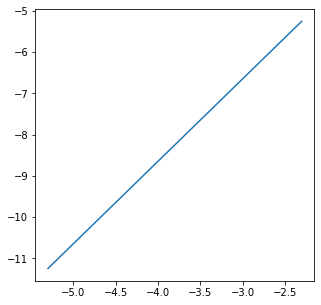

In [35]:

def unite(x,y):
    return x**2 + y**2

c=1


def methode_triangle(f,x0,y0,p,d,n):
    #On recupère les valeurs de level_curve
    curve=level_curve_rec(f,x0,y0,d,n)
    #on boucle les valeurs
    curve[0].append(curve[0][0]) 
    curve[1].append(curve[1][0])
    
    aire=0
    for i in range(len(curve[0])-1):
        aire += ((curve[0][i+1]-p[0])*(curve[1][i]-p[1])-(curve[0][i]-p[0])*(curve[1][i+1]-p[1]))/2 #calcul du det des deux vercteurs/2
    return aire, curve


liste_erreur=[]
liste_delta=np.array([0.1,0.05,0.01,0.005])
for i in liste_delta:
    A = np.pi - methode_triangle(unite,1.,0.,[0.,0.],i,N*int(1/i))[0]
    print("Pour delta = ",i," ,l'erreur est de = ",A)
    liste_erreur.append(np.log(A))
print("Il y a bien convergence de la méthode")
print("On trace le log de l'erreur en fonction du log de delta. On trouve une droite environ ln(epsilon)=2ln(delta).D'ou epsilon~delta**2")
plt.plot(np.log(liste_delta),liste_erreur)
plt.show()


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [36]:
#Pour p=[-2.,-2.]

print(methode_triangle(unite,1.,0.,[-2.,-2.],0.1,N)[0])
print("Le résultat est correct")
#en plaçant le point de référence à l'extérieur, les aires des triangles n'auront pas toutes le même signe
#ce qui fait que les aires des triangles qui se chevauchent se compensent 
#et il ne reste que l'aire de la figure
#En effet si les points considérés arrivent dans le sens trigo, l'aire sera comptée positivement.
#Sinon, elle sera comptée négativement


3.136370447345743
Le résultat est correct


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [37]:
p=[0.,0.]
def reunion (centre1,centre2):
    def cercle1(x,y):
        return np.sqrt((x-centre1[0])**2+(y-centre1[1])**2)
    def cercle2(x,y):
        return np.sqrt((x-centre2[0])**2+(y-centre2[1])**2)
    valeur1=level_curve_rec(cercle1,centre1[0]+1,centre1[1],0.1,N)
    valeur2=level_curve_rec(cercle2,centre2[0]+1,centre2[1],0.1,N)
    valeurs=[[],[]]
    valeurs[0]=valeur1[0]+valeur2[0]
    valeurs[1]=valeur1[1]+valeur2[1]
    valeurs[0].append(valeurs[0][0]) #on boucle les valeurs
    valeurs[1].append(valeurs[1][0])
    aire=0
    for i in range(len(valeurs[0])-1):
        aire+= ((valeurs[0][i+1]-p[0])*(valeurs[1][i]-p[1])-(valeurs[0][i]-p[0])*(valeurs[1][i+1]-p[1]))/2 #calcul du det des deux vercteurs/2
    return aire

results=reunion([0.,0.],[3.,3.])
print(results)
print("On obtient bien la somme de l'aire de deux cerlces de rayon 1")

#De même, comme la suite de variable est bouclée, toute aire excédentaire
#est comptée deux fois : une fois négativement et une fois positivement suivant
#si les deux points arrivent dans le sens trigo ou le sens anti-trigo



6.272740893713971
On obtient bien la somme de l'aire de deux cerlces de rayon 1


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [38]:

def area_triangles(x,y):
    #p est choisi quelconque, ici égal à 0,0 pour éviter des calculs
    
    #on boucle la série de points
    x.append(x[0]) 
    y.append(y[0])
    
    #On calcul l'aire par la méthode des triangles
    aire=0
    for i in range(len(x)-1):
        aire+= (x[i+1]*y[i]-x[i]*y[i+1])/2 #calcul du determinant des deux vercteurs/2
    return aire

result=level_curve_rec(unite,1.,0.,0.1,N)
print("L'aire du cercle unite",area_triangles(result[0],result[1]))


L'aire du cercle unite 3.136370447345741


In [39]:
#En terme de complexité, area_triangles est en O(n) tandis que area_tectangles est en O(n**2) avec n la série de point à traiter

In [40]:
#On procède à d'autres tests
c=0.8
result=level_curve_rec(f1,0.4472135970019964, 0.4472135970019964,0.1,N)
print("l'aire délimitée par l'équation f1=0.8 avec la méthode des triangles", area_triangles(result[0],result[1]))
print("l'aire délimitée par l'équation f1=0.8 avec la méthode des carrés",area_squares(f1, 0.8, 0.01, -1, 1, -1, 1))

c=1.
result=level_curve_rec(f2,1.,0.,0.1,N)
print("l'aire délimitée par l'équation f2=1 avec la méthode des triangles", area_triangles(result[0],result[1]))
print("l'aire délimitée par l'équation f2=1 avec la méthode des carrés",area_squares(f2, 1., 0.01, -3, 3, -3, 3))
print("l'aire est différente car la méthode des carrés comptes toutes les lignes de niveaux comprises dans le carré initial tandis que celle des triangle ne compte que l'aire de la courbe tracée ","\n")

c=-2.4
result=level_curve_rec(f3,-0.06454267749899904, -0.3473846556074643,0.1,N)
print("l'aire délimitée par l'équation f3=-2.4 avec la méthode des triangles", area_triangles(result[0],result[1]))
print("l'aire délimitée par l'équation f3=-2.4 avec la méthode des carrés",area_squares(f3, -2.4, 0.01, -4, 4, -4, 4))
print("De même l'aire est différente")

l'aire délimitée par l'équation f1=0.8 avec la méthode des triangles 0.8832920591055946
l'aire délimitée par l'équation f1=0.8 avec la méthode des carrés 0.8889999999999184
l'aire délimitée par l'équation f2=1 avec la méthode des triangles 3.6666545801214667
l'aire délimitée par l'équation f2=1 avec la méthode des carrés 2.243100000000309
l'aire est différente car la méthode des carrés comptes toutes les lignes de niveaux comprises dans le carré initial tandis que celle des triangle ne compte que l'aire de la courbe tracée  

l'aire délimitée par l'équation f3=-2.4 avec la méthode des triangles 4.666321785761606
l'aire délimitée par l'équation f3=-2.4 avec la méthode des carrés 5.961999999999444
De même l'aire est différente


In [41]:
#Un avantage de la méthode des rectangles est qu'il n'y a pas besoin de réfléchir à l'avance aux courbes à tracer
#Mais la méthode des triangles est plus efficace en terme de complexité